In [60]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import json

from helpers.gaussian_blur import gaussian_blur
from helpers.grey_scale import grey_scale
from helpers.morpho_trafo import closing
from helpers.contours import contour, find_contours
from helpers.vertical_edges import detect_vertical_edges, otsu_intraclass_variance
from helpers.cnn_model import CNNModel

In [61]:
class Plate_Reader:
    def __init__(self, model_path='best_model.pth'):
        self.model = CNNModel()
        self.model.load_state_dict(torch.load(model_path))
        self.model.eval()

        # read the label_map.json file
        with open('./EMNIST/labels_map.json', 'r') as f:
            self.labels_map = json.load(f)

    def read_plate(self, segments_list):
        potential_chars = []
        with torch.no_grad():
            for i, segment in  enumerate(segments_list):
                segment = segment.reshape(1, 28, 28)  # Reshape to (1, 28, 28)

                output = self.model(segment.unsqueeze(0))  # Add batch dimension

                # apply soft max to the output
                output = torch.nn.functional.softmax(output, dim=1)

                # make a dict with label and probability for the top 5 probabilities
                top5_prob, top5_idx = torch.topk(output, 5)
                top5_labels = [self.labels_map[str(idx.item())] for idx in top5_idx[0]]
                top5_prob = top5_prob[0].numpy()

                char_dict = {label: prob for label, prob in zip(top5_labels, top5_prob)}
                potential_chars.append(char_dict)

        # given the potential chars and probabilities, calculate every possible plate number and its probability
        plate_numbers = []
        plate_probs = []
        
        def backtrack(current_plate, current_prob, index):
            if index == len(potential_chars):
                plate_numbers.append(current_plate)
                plate_probs.append(current_prob)
                return
            for char, prob in potential_chars[index].items():
                backtrack(current_plate + char, current_prob * prob, index + 1)

        backtrack("", 1.0, 0)

        # find the 5 plate numbers with the highest probabilities
        top5_plate_probs, top5_plate_idx = torch.topk(torch.tensor(plate_probs), 5)
        top5_plate_numbers = [plate_numbers[idx.item()] for idx in top5_plate_idx]

        print("Most likely plate numbers with probabilities:")
        for plate, prob in zip(top5_plate_numbers, top5_plate_probs):
            if prob.item() > 0.0001:
                print(f"Plate: {plate}, Probability: {100 * prob.item():.4f} %")

In [62]:
class License_Plate:
    def __init__(self, image):
        self.image = image

        self.height, self.width = self.image.shape

    def process_license_plate(self):
        # first step: binarise the image
        self._binarise()
        print("Binarisation complete.")
        # second step: find contours in the binary image
        self._find_contours()
        print("Contour detection complete.")
        # third step: filter contours based on area and aspect ratio
        self._filter_contours()
        print("Contour filtering complete.")
        # fourth step: sort contours from left to right
        self._sort_contours()
        print("Contour sorting complete.")
        # fifth step: isolate character images
        self._isolate_characters()
        print("Character isolation complete.")
        # sixth step: square character images
        self._square_characters()
        print("Character squaring complete.")
        # seventh step: make character images 28x28 in EMNIST format
        self._make_EMNIST_format()
        print("Character resizing to 28x28 complete.")

    def _binarise(self):
        # calculate otsu's threshold for binarisation
        otsu_threshold = min(
        np.linspace(np.min(np.abs(self.image)) + 0.001, np.max(np.abs(self.image)), 100),
        key=lambda th: otsu_intraclass_variance(np.abs(self.image), th))

        self.binary_image = np.where(np.abs(self.image) >= otsu_threshold, 0, 1) # inversion of values, such that 0 means background and 1 means contour

    def _find_contours(self):
        self.contours = find_contours(self.binary_image)
        
    def _filter_contours(self):
        # filter contours, which occupy between 0.5% and 3% of the total area
        total_area = self.height * self.width

        # print percentual area and aspect ration
        #for cont in self.contours:
        #    perc_area = cont.area / total_area
        #    aspect_ratio = cont.calculate_aspect_ratio()
        #    print(f"Contour label: {cont.label}, Area: {perc_area*100:.3f}%, Aspect Ratio: {aspect_ratio:.3f}")

        self.filtered_contours = [cont for cont in self.contours if 0.005 * total_area < cont.area < 0.05 * total_area]

        # also filter aspect ratios 
        self.filtered_contours = [cont for cont in self.filtered_contours if 0.3 < cont.calculate_aspect_ratio() < 0.75]

    def _sort_contours(self):
        # sort contours from left to right
        self.filtered_contours.sort(key=lambda cont: cont._centre()[1])

    def _isolate_characters(self):
        self.character_images = []
        for cont in self.filtered_contours:
            (min_y, min_x), (max_y, max_x) = cont.bounding_box
            char_image = self.binary_image[max(min_y, 0):min(max_y+1, self.binary_image.shape[0]), max(min_x, 0):min(max_x+1, self.binary_image.shape[1])]
            self.character_images.append(char_image)

    def _square_characters(self):
        self.squared_character_images = []
        for char_img in self.character_images:
            h, w = char_img.shape
            diff = h - w
            # due to aspect ratio filter, the height is either equal to or larger than the width, i.e. diff >= 0
            if diff > 0:
                # append zeros left and right
                pad_left = diff // 2
                pad_right = diff - pad_left
                squared_char_img = np.pad(char_img, ((0, 0), (pad_left, pad_right)), mode='constant', constant_values=0)

            else:
                squared_char_img = char_img

            self.squared_character_images.append(squared_char_img)

    def _make_EMNIST_format(self):
        self.squared_character_images_28x28 = []

        for char_img in self.squared_character_images:
            h, w = char_img.shape
            if h > 28 and w > 28:
                # determine kernel size
                kernel_size_h = h // 28 + 2 if (h // 28) % 2 == 1 else (h // 28 + 3)
                kernel_size_w = w // 28 + 2 if (w // 28) % 2 == 1 else (w // 28 + 3)
                kernel_size = max(kernel_size_h, kernel_size_w)
    
                # apply gaussian blur
                blurred_char_img = gaussian_blur(char_img, kernel_size=kernel_size, sigma=kernel_size/3)
        
                # downsample by taking every nth pixel
                downsampled_char_img = blurred_char_img[::kernel_size, ::kernel_size]
        
                # if the downsampled image is not exactly 28x28, pad with zeros
                dh, dw = downsampled_char_img.shape[:2]
        
                pad_h = 28 - dh
                pad_w = 28 - dw
                pad_top = pad_h // 2
                pad_bottom = pad_h - pad_top
                pad_left = pad_w // 2
                pad_right = pad_w - pad_left
        
                downsized_char_img = np.pad(downsampled_char_img, ((pad_top, pad_bottom), (pad_left, pad_right),(0, 0)), mode='constant', constant_values=0)

            else:
                # if the character image is smaller than 28x28, just pad with zeros
                pad_h = 28 - h
                pad_w = 28 - w
                pad_top = pad_h // 2
                pad_bottom = pad_h - pad_top
                pad_left = pad_w // 2
                pad_right = pad_w - pad_left
    
                downsized_char_img = np.pad(char_img, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=0)

            self.squared_character_images_28x28.append(downsized_char_img)

In [63]:
class Image:
    def __init__(self, path):
        # read the path to get the image data
        self.img = plt.imread(path)
        # get image dimensions
        self.height, self.width, _ = self.img.shape
        
        # preprocess the image:
        # determine kernel size for gaussian blur -- 200 is arbitrary but seems to work well
        kernel_size = (min(self.height, self.width) // 200 + 1) if ((min(self.height, self.width) // 200) % 2 == 0) else (min(self.height, self.width) // 200)
        # blur the image to remove small noise
        self.img = gaussian_blur(self.img, kernel_size=kernel_size, sigma=kernel_size/5) # the image is now in float32 format
        # convert to grey scale
        self.img = grey_scale(self.img)

    def return_license_plate(self):
        # first step: detect vertical edges
        self._detect_vertical_edges()
        print("Vertical edges detected.")
        # second step: apply morphological closing transformation
        self._closing_transformation()
        print("Morphological closing transformation applied.")
        # third step: find all contours in the processed image
        self._find_all_contours()
        print("All contours found.")
        # fourth step: identify contours that could be license plates
        self._identify_license_plate_contours()
        print("License plate contours identified.")
        # fifth step: return the identified license plate as License_Plate object
        self._return_license_plate()
        print("License plate returned.")
        return self.license_plate

    def _detect_vertical_edges(self):
        self.image_vertical_edges = detect_vertical_edges(self.img)
    
    def _closing_transformation(self):
        self.image_closed = closing(self.image_vertical_edges)
    
    def _find_all_contours(self):
        self.contours = find_contours(self.image_closed)
    
    def _identify_license_plate_contours(self):
        # first check:
        # filter out all contours that have an area below 0.25% or above 2% of the total image area
        min_area = 0.0025 * self.height * self.width
        max_area = 0.015 * self.height * self.width

        self.license_plate_contours = [cnt for cnt in self.contours 
                                       if min_area <= cnt.area <= max_area]

        # second check:
        # find the contour whose bounding box is most similar to the aspect ratio of a license plate (approx. 4.7:1)
        target_aspect_ratio = 4.7
        best_cnt = None
        best_ratio_diff = float('inf')
        for cnt in self.license_plate_contours:
            aspect_ratio = cnt.calculate_aspect_ratio()
            ratio_diff = abs(aspect_ratio - target_aspect_ratio)
            if ratio_diff < best_ratio_diff:
                best_ratio_diff = ratio_diff
                best_cnt = cnt
        
        self.license_plate_contour = best_cnt

        # license plate image is the cropped region of the grey scale image
        (min_y, min_x), (max_y, max_x) = self.license_plate_contour.bounding_box
        self.license_plate_image = self.img[min_y:max_y+1, min_x:max_x+1]
    
    def _return_license_plate(self):
        self.license_plate = License_Plate(self.license_plate_image)

In [81]:
img = Image('img/NL.jpg')

In [82]:
lp = img.return_license_plate()

Vertical edges detected.
Morphological closing transformation applied.
All contours found.
License plate contours identified.
License plate returned.


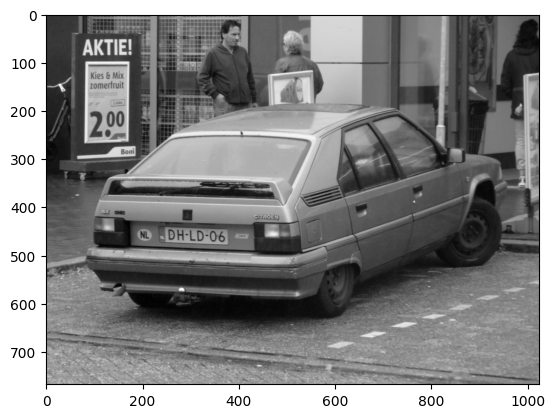

In [83]:
plt.imshow(img.img, cmap='gray');

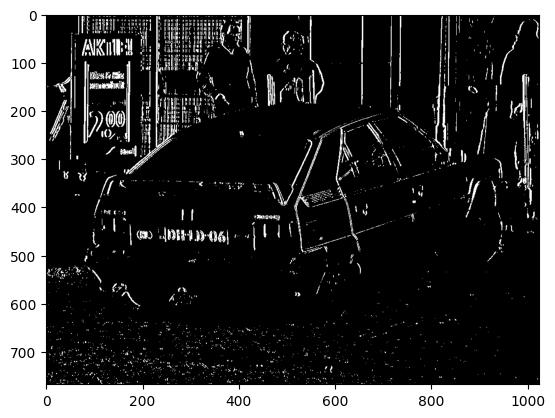

In [84]:
plt.imshow(img.image_vertical_edges, cmap='gray');

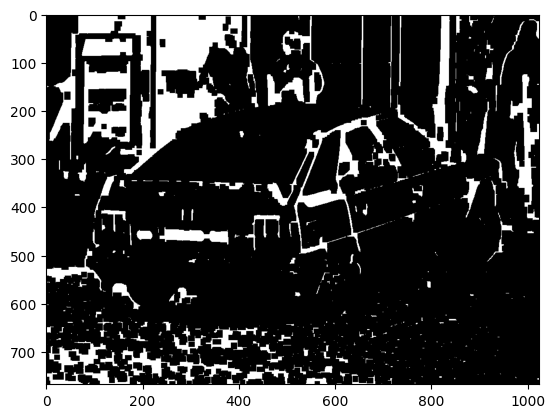

In [85]:
plt.imshow(img.image_closed, cmap='gray');

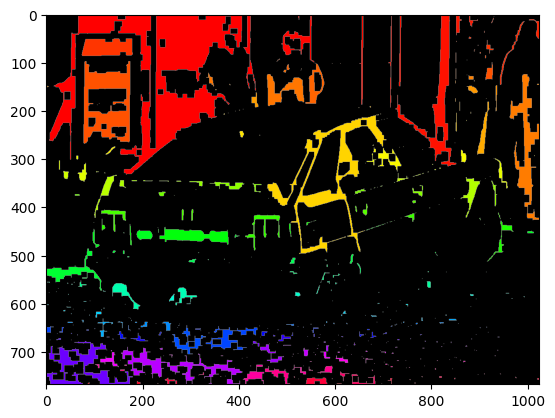

In [86]:
# take the closed image and color the contours differently, according to their label
image_closed = np.zeros_like(img.image_closed, dtype=np.float32)
num_c = len(img.contours)

for cnt in img.contours:
    # get the pixels
    pixels = np.array(cnt.pixels)
    # give these pixels a color according to the contour label (cnt.label/num_c)
    image_closed[pixels[:, 0], pixels[:, 1]] = (np.float32(cnt.label) / num_c)

plt.imshow(np.where(image_closed == 0, image_closed, np.nan), cmap='gray');
# plot the image, only where the value is > 0
plt.imshow(np.where(image_closed > 0, image_closed, np.nan), cmap='hsv');

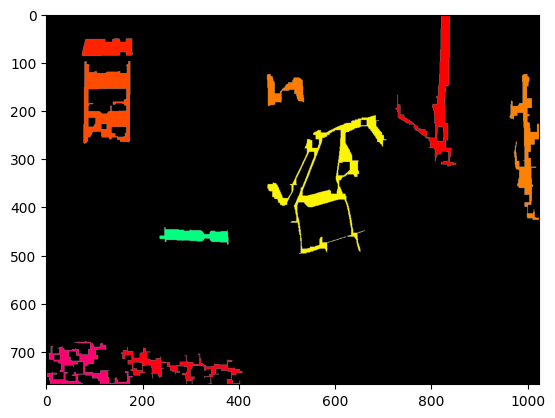

In [87]:
# take the closed image and color the contours differently, according to their label
image_closed = np.zeros_like(img.image_closed, dtype=np.float32)
num_c = len(img.license_plate_contours)

for cnt in img.license_plate_contours:
    # get the pixels
    pixels = np.array(cnt.pixels)
    # give these pixels a color according to the contour label (cnt.label/num_c)
    image_closed[pixels[:, 0], pixels[:, 1]] = (np.float32(cnt.label) / num_c)

plt.imshow(np.where(image_closed == 0, image_closed, np.nan), cmap='gray');
# plot the image, only where the value is > 0
plt.imshow(np.where(image_closed > 0, image_closed, np.nan), cmap='hsv');

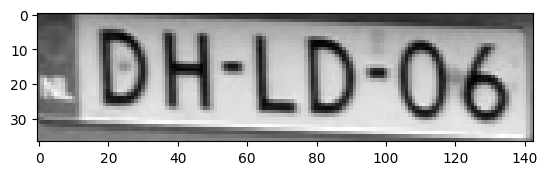

In [88]:
plt.imshow(img.license_plate_image, cmap='gray');

In [89]:
lp.process_license_plate()

Binarisation complete.
Contour detection complete.
Contour filtering complete.
Contour sorting complete.
Character isolation complete.
Character squaring complete.
Character resizing to 28x28 complete.


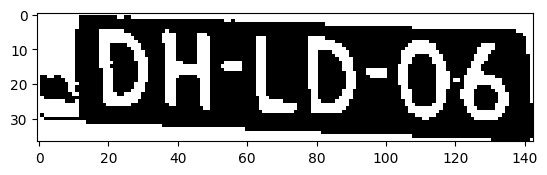

In [90]:
plt.imshow(lp.binary_image, cmap='gray');

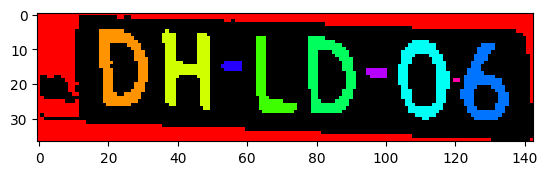

In [91]:
# take the closed image and color the contours differently, according to their label
image_closed = np.zeros_like(lp.binary_image, dtype=np.float32)
num_c = len(lp.contours)

for cnt in lp.contours:
    # get the pixels
    pixels = np.array(cnt.pixels)
    # give these pixels a color according to the contour label (cnt.label/num_c)
    image_closed[pixels[:, 0], pixels[:, 1]] = (np.float32(cnt.label) / num_c)

plt.imshow(np.where(image_closed == 0, image_closed, np.nan), cmap='gray');
# plot the image, only where the value is > 0
plt.imshow(np.where(image_closed > 0, image_closed, np.nan), cmap='hsv');

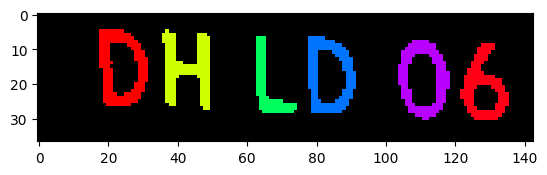

In [92]:
# take the closed image and color the contours differently, according to their label
image_closed = np.zeros_like(lp.binary_image, dtype=np.float32)
num_c = len(lp.filtered_contours)

for cnt in lp.filtered_contours:
    # get the pixels
    pixels = np.array(cnt.pixels)
    # give these pixels a color according to the contour label (cnt.label/num_c)
    image_closed[pixels[:, 0], pixels[:, 1]] = (np.float32(cnt.label) / num_c)

plt.imshow(np.where(image_closed == 0, image_closed, np.nan), cmap='gray');
# plot the image, only where the value is > 0
plt.imshow(np.where(image_closed > 0, image_closed, np.nan), cmap='hsv');

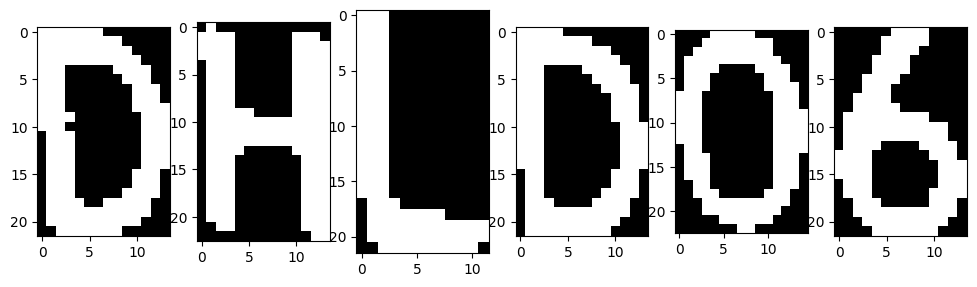

In [93]:
chars_imgs = lp.character_images
num_chars = len(chars_imgs)
# plot each char image
fig, axs = plt.subplots(1, num_chars, figsize=(num_chars * 2, 4))
for i in range(num_chars):
    axs[i].imshow(chars_imgs[i], cmap='gray')
plt.show()

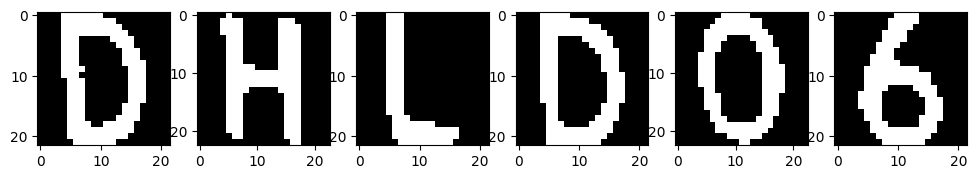

In [94]:
sq_char_imgs = lp.squared_character_images
num_sq_chars = len(sq_char_imgs)
# plot each squared char image
fig, axs = plt.subplots(1, num_sq_chars, figsize=(num_sq_chars * 2, 4))
for i in range(num_sq_chars):
    axs[i].imshow(sq_char_imgs[i], cmap='gray')
plt.show()

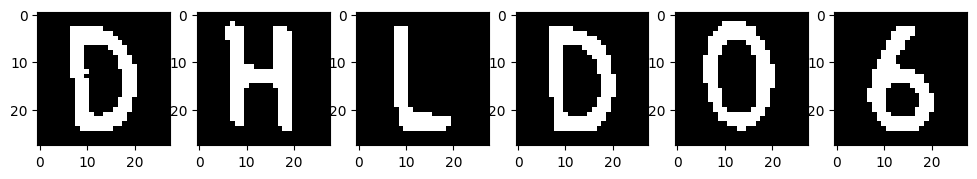

In [95]:
sq_chars_imgs_emnist = lp.squared_character_images_28x28
num_sq_chars = len(sq_chars_imgs_emnist)
# plot each squared char image in EMNIST format
fig, axs = plt.subplots(1, num_sq_chars, figsize=(num_sq_chars * 2, 4))
for i in range(num_sq_chars):
    axs[i].imshow(sq_chars_imgs_emnist[i], cmap='gray')
plt.show();

In [96]:
LP_reader = Plate_Reader(model_path='best_model.pth')

In [97]:
LP_reader.read_plate(torch.tensor(np.array(sq_chars_imgs_emnist), dtype=torch.float32))

Most likely plate numbers with probabilities:
Plate: DHLD06, Probability: 92.3503 %
Plate: DHMD06, Probability: 5.8952 %
Plate: DHLDO6, Probability: 1.5052 %
Plate: DGLD06, Probability: 0.1417 %
Plate: DHMDO6, Probability: 0.0961 %
